## Final Project Submission

Please fill out:
* Student name: Alec Schonfeld
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Mark
* Blog post URL:


# Business Understanding

---

### Project Prompt

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

### Goal

Identify the variables that lead to the most viral and profitable movies and reccomend our new studio creates these types of films

# Data Understanding

---

### Dataset Overview
Most Important Datasets to Examine:

1. im.db.zip - Zipped SQLite database containing data from imdb (movie_basics and movie_ratings tables are most relevant)
2. bom.movie_gross.csv.gz - Compressed CSV file containing financial information 

Other Datasets:
1. rt.movie_info.tsv
2. rt.reviews.tsv
3. tmdb.movies.csv
4. tn.movie_budgets.csv


### Data Preparation

#### Dataset 1: im.db.zip

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import zipfile
import sqlite3
import os

# Path to your zip file
zip_file_path = r'C:\Users\alecs\OneDrive\Desktop\Flatiron School\Phase 2 Project\dsc-phase-2-project-as\datasets\im.db.zip'

# Directory to extract the file
extract_dir = r'C:\Users\alecs\OneDrive\Desktop\Flatiron School\Phase 2 Project\dsc-phase-2-project-as\datasets'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Path to the SQLite database file
db_path = os.path.join(extract_dir, 'im.db')

# Check if the file exists
if os.path.exists(db_path):
    print("Database file extracted successfully.")
    
    try:
        # Connect to the SQLite database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        
        # Retrieve and print all table names
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()
        
        print("Tables in the database:")
        for table in tables:
            print(table[0])
        
        # Close the connection
        conn.close()
    
    except sqlite3.Error as e:
        print("SQLite error:", e)
    
    except Exception as e:
        print("Error:", e)

else:
    print("Database file does not exist at the specified path.")


Database file extracted successfully.
Tables in the database:
movie_basics
directors
known_for
movie_akas
movie_ratings
persons
principals
writers


We are told that movie_basics and movie_ratings are the most important tables to analyze so we will start with those

In [3]:
# Connect to SQLite database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Execute query to fetch data from table
cursor.execute("SELECT * FROM movie_basics LIMIT 10;")
rows = cursor.fetchall()

# Print table data
print(f"First 10 rows from table: movie_basics")
for row in rows:
    print(row)

First 10 rows from table: movie_basics
('tt0063540', 'Sunghursh', 'Sunghursh', 2013, 175.0, 'Action,Crime,Drama')
('tt0066787', 'One Day Before the Rainy Season', 'Ashad Ka Ek Din', 2019, 114.0, 'Biography,Drama')
('tt0069049', 'The Other Side of the Wind', 'The Other Side of the Wind', 2018, 122.0, 'Drama')
('tt0069204', 'Sabse Bada Sukh', 'Sabse Bada Sukh', 2018, None, 'Comedy,Drama')
('tt0100275', 'The Wandering Soap Opera', 'La Telenovela Errante', 2017, 80.0, 'Comedy,Drama,Fantasy')
('tt0111414', 'A Thin Life', 'A Thin Life', 2018, 75.0, 'Comedy')
('tt0112502', 'Bigfoot', 'Bigfoot', 2017, None, 'Horror,Thriller')
('tt0137204', 'Joe Finds Grace', 'Joe Finds Grace', 2017, 83.0, 'Adventure,Animation,Comedy')
('tt0139613', 'O Silêncio', 'O Silêncio', 2012, None, 'Documentary,History')
('tt0144449', 'Nema aviona za Zagreb', 'Nema aviona za Zagreb', 2012, 82.0, 'Biography')


In [4]:
# Lets look at all the columns in the table
pd.read_sql("""
select *
from movie_basics
limit 1""",conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"


Columns in the movie_basics dataset include a movie_id, primary_title, original_title, start_year, runtime_minutes, genres

The most interesting ones to analyze will be the runtime and genres as variables that impact success

The other table we should look into is movie_ratings

In [5]:
# Lets look at all the columns in the table
pd.read_sql("""
select *
from movie_ratings
limit 1""",conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31


In [6]:
# Let us combine both of these tables so we can evaluate all of the important criteria from each in one view 

# Properly formatted SQL query within triple quotes
basic_and_rating = pd.read_sql("""
    SELECT 
        mb.movie_id, 
        mr.averagerating AS avg_rating, 
        mr.numvotes AS num_of_votes, 
        mb.primary_title, 
        mb.runtime_minutes AS length, 
        mb.genres
    FROM 
        movie_basics AS mb
    JOIN 
        movie_ratings AS mr ON mb.movie_id = mr.movie_id;
    """, conn)

basic_and_rating.shape


(73856, 6)

The shape of this combined dataset contains 6 columns and ~74k rows

In [7]:
basic_and_rating.head()

,movie_id,avg_rating,num_of_votes,primary_title,length,genres
0,tt0063540,7.0,77,Sunghursh,175.0,"Action,Crime,Drama"
1,tt0066787,7.2,43,One Day Before the Rainy Season,114.0,"Biography,Drama"
2,tt0069049,6.9,4517,The Other Side of the Wind,122.0,Drama
3,tt0069204,6.1,13,Sabse Bada Sukh,NaN,"Comedy,Drama"
4,tt0100275,6.5,119,The Wandering Soap Opera,80.0,"Comedy,Drama,Fantasy"


Note: 1 movie can belong to multiple genres

Now we will clean this combined dataset for any NA values

In [8]:
basic_and_rating.dropna(inplace=True)
basic_and_rating['num_of_votes'] = basic_and_rating['num_of_votes'].astype(int)
basic_and_rating['avg_rating'] = basic_and_rating['avg_rating'].astype(float)

Let's clean the genre column so we can evaluate the correlation between genre and important movie outcomes

In [9]:
# Split the genre column so we can evalute individually 

genres_split = basic_and_rating['genres'].str.split(',', expand=True)
genres_split = genres_split.stack().reset_index(level=1, drop=True).to_frame('genre')
basic_and_rating = basic_and_rating.drop('genres', axis=1).join(genres_split)

In [10]:
# Basic statistics

print(basic_and_rating.describe())


          avg_rating  num_of_votes         length
count  118437.000000  1.184370e+05  118437.000000
mean        6.294281  5.786773e+03      95.090757
std         1.446315  3.964054e+04     156.784852
min         1.000000  5.000000e+00       3.000000
25%         5.400000  1.800000e+01      82.000000
50%         6.400000  7.900000e+01      92.000000
75%         7.300000  5.110000e+02     105.000000
max        10.000000  1.841066e+06   51420.000000


Takeaways on the basic_and_rating dataframe:
- avg_rating ranges from 1-10 with an average of 6.29

In [11]:
# Group the genres together and combine the num of votes and avg rating score to understand which genres scored highsest
genre_grouped_num_of_votes = basic_and_rating.groupby('genre').agg({
    'num_of_votes': 'mean'
}).reset_index()
print(genre_grouped_num_of_votes)

          genre  num_of_votes
0        Action  16059.485946
1         Adult     68.000000
2     Adventure  23259.583817
3     Animation   9503.384520
4     Biography   5849.763878
5        Comedy   4781.572709
6         Crime   9132.800369
7   Documentary    286.786945
8         Drama   4206.977143
9        Family   2670.517487
10      Fantasy  13370.734891
11    Game-Show   1734.500000
12      History   2898.483358
13       Horror   3449.150499
14        Music   2955.349241
15      Musical   2171.189655
16      Mystery   8532.349948
17         News    214.406957
18   Reality-TV     30.307692
19      Romance   4497.207664
20       Sci-Fi  20974.268555
21        Short      8.000000
22        Sport   3412.451319
23     Thriller   6346.654490
24          War   3374.472956
25      Western   9578.042969


Lets sort the genres based on these 2 columns

In [12]:
genre_grouped_num_of_votes_sorted = genre_grouped_num_of_votes.sort_values(by=['num_of_votes'], ascending=[False])
genre_grouped_num_of_votes_sorted

,genre,num_of_votes
2,Adventure,23259.583817
20,Sci-Fi,20974.268555
0,Action,16059.485946
10,Fantasy,13370.734891
25,Western,9578.042969
3,Animation,9503.384520
6,Crime,9132.800369
16,Mystery,8532.349948
23,Thriller,6346.654490
4,Biography,5849.763878


Now lets look at genre sorted by avg rating


In [13]:
# Group the genres together and combine the num of votes and avg rating score to understand which genres scored highsest
genre_grouped_avg_rating = basic_and_rating.groupby('genre').agg({
    'avg_rating': 'mean'
}).reset_index()
print(genre_grouped_avg_rating)

          genre  avg_rating
0        Action    5.784437
1         Adult    3.950000
2     Adventure    6.178873
3     Animation    6.250836
4     Biography    7.169185
5        Comedy    6.014110
6         Crime    6.110742
7   Documentary    7.316787
8         Drama    6.391692
9        Family    6.401362
10      Fantasy    5.894413
11    Game-Show    7.300000
12      History    7.048928
13       Horror    4.934538
14        Music    7.070662
15      Musical    6.524451
16      Mystery    5.891346
17         News    7.278783
18   Reality-TV    6.600000
19      Romance    6.148059
20       Sci-Fi    5.431494
21        Short    8.800000
22        Sport    6.964604
23     Thriller    5.592140
24          War    6.573962
25      Western    5.824219


In [14]:
genre_grouped_avg_rating_sorted = genre_grouped_avg_rating.sort_values(by=['avg_rating'],ascending=False)
genre_grouped_avg_rating_sorted

,genre,avg_rating
21,Short,8.800000
7,Documentary,7.316787
11,Game-Show,7.300000
17,News,7.278783
4,Biography,7.169185
14,Music,7.070662
12,History,7.048928
22,Sport,6.964604
18,Reality-TV,6.600000
24,War,6.573962


Now we will look at the correlation between genres and these 2 columns

In [15]:
genre_grouped_combined = basic_and_rating.groupby('genre').agg({
    'num_of_votes': 'mean',
    'avg_rating':'mean'
}).reset_index()

genre_grouped_combined 

,genre,num_of_votes,avg_rating
0,Action,16059.485946,5.784437
1,Adult,68.000000,3.950000
2,Adventure,23259.583817,6.178873
3,Animation,9503.384520,6.250836
4,Biography,5849.763878,7.169185
5,Comedy,4781.572709,6.014110
6,Crime,9132.800369,6.110742
7,Documentary,286.786945,7.316787
8,Drama,4206.977143,6.391692
9,Family,2670.517487,6.401362


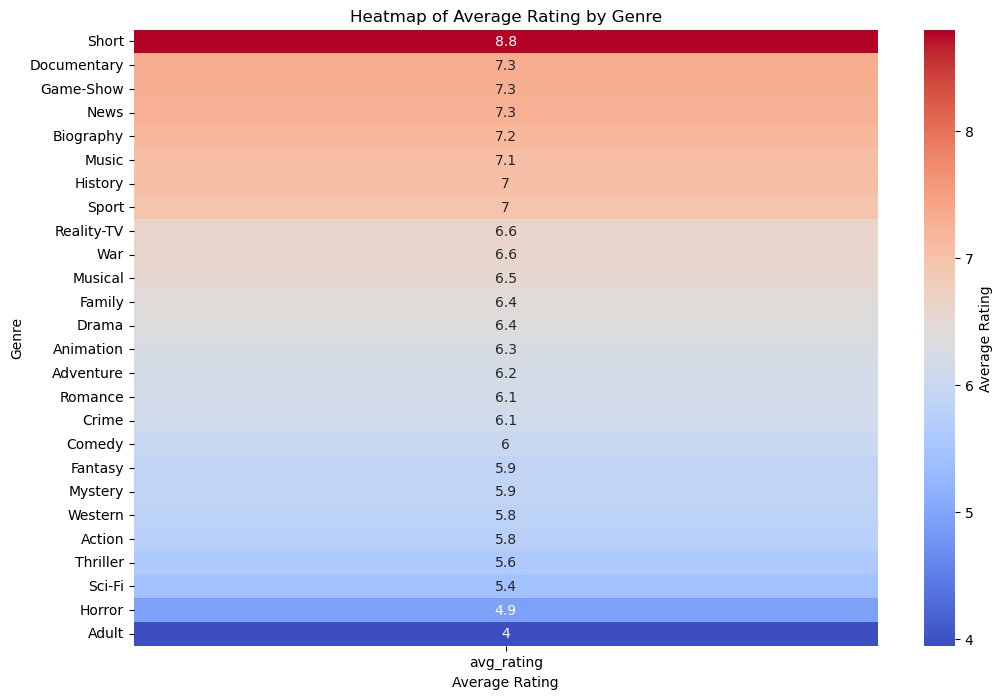

In [16]:
# Set the genre as the index
genre_grouped_avg_rating_sorted.set_index('genre', inplace=True)

# Plot heatmap for avg_rating
plt.figure(figsize=(12, 8))
sns.heatmap(genre_grouped_avg_rating_sorted[['avg_rating']], annot=True, cmap='coolwarm', center=genre_grouped_combined['avg_rating'].mean(), cbar_kws={'label': 'Average Rating'})
plt.title('Heatmap of Average Rating by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.show()

Text(0.5, 1.0, 'Average Rating by Genre')

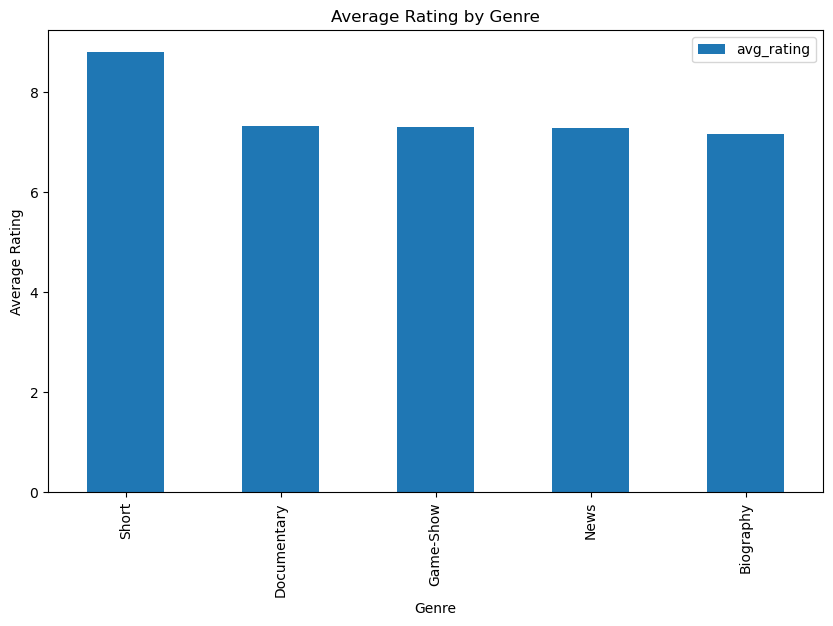

In [17]:
top_5_graph = genre_grouped_avg_rating_sorted.head(5)

fig,ax = plt.subplots(figsize=(10,6))

top_5_graph.plot(kind='bar',ax=ax)
plt.ylabel('Average Rating')
plt.xlabel('Genre')
plt.title('Average Rating by Genre')

The top 5 genres by average rating are: 
- Short 
- Documentary
- Game-Show
- News
- Biography

In [18]:
# lets do the same for number of votes

genre_grouped_combined_sorted = genre_grouped_combined.sort_values(by=['num_of_votes'], ascending = False)
top_5_votes = genre_grouped_combined_sorted.head(5)
top_5_votes

,genre,num_of_votes,avg_rating
2,Adventure,23259.583817,6.178873
20,Sci-Fi,20974.268555,5.431494
0,Action,16059.485946,5.784437
10,Fantasy,13370.734891,5.894413
25,Western,9578.042969,5.824219


Text(0.5, 1.0, 'Number of Votes by Genre')

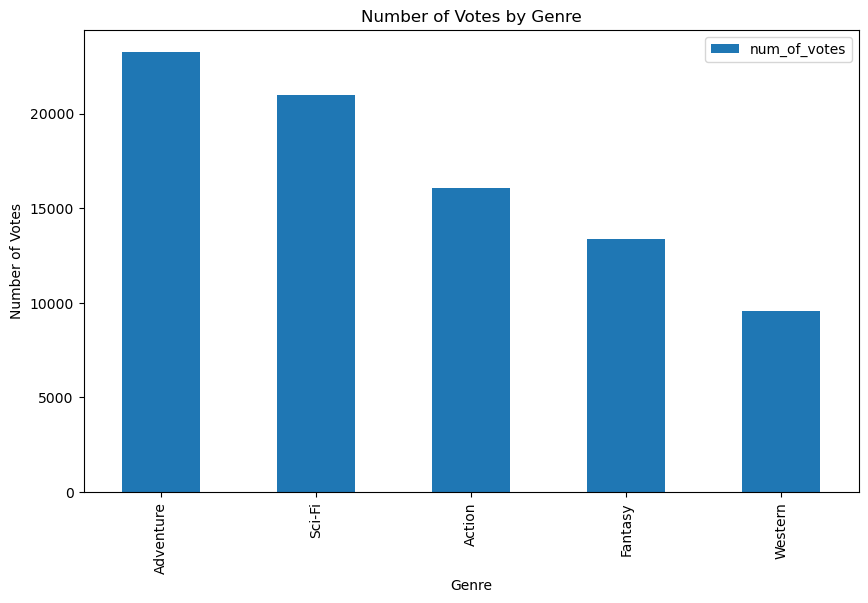

In [19]:
# plot bar graph by number of votes

fig,ax = plt.subplots(figsize= (10,6))

top_5_votes.plot(kind='bar',ax=ax,x='genre',y='num_of_votes')
plt.ylabel('Number of Votes')
plt.xlabel('Genre')
plt.title('Number of Votes by Genre')

We will create a ranking column for num of votes and avg rating within the group and combine them to see which genre has the highest rank

In [20]:
# Create a copy of the original DataFrame to avoid overwriting
ranked_genre_grouped = genre_grouped_combined.copy()

# Calculate ranks for num_of_votes and avg_rating
ranked_genre_grouped['rank_num_of_votes'] = ranked_genre_grouped['num_of_votes'].rank(method='min', ascending=False)
ranked_genre_grouped['rank_avg_rating'] = ranked_genre_grouped['avg_rating'].rank(method='min', ascending=False)

# Display the new DataFrame with ranks
print(ranked_genre_grouped)

          genre  num_of_votes  avg_rating  rank_num_of_votes  rank_avg_rating
0        Action  16059.485946    5.784437                3.0             22.0
1         Adult     68.000000    3.950000               24.0             26.0
2     Adventure  23259.583817    6.178873                1.0             15.0
3     Animation   9503.384520    6.250836                6.0             14.0
4     Biography   5849.763878    7.169185               10.0              5.0
5        Comedy   4781.572709    6.014110               11.0             18.0
6         Crime   9132.800369    6.110742                7.0             17.0
7   Documentary    286.786945    7.316787               22.0              2.0
8         Drama   4206.977143    6.391692               13.0             13.0
9        Family   2670.517487    6.401362               19.0             12.0
10      Fantasy  13370.734891    5.894413                4.0             19.0
11    Game-Show   1734.500000    7.300000               21.0    

In [21]:
ranked_genre_grouped['Total'] = ranked_genre_grouped['rank_num_of_votes'] +  ranked_genre_grouped['rank_avg_rating']

Creating a Total column to capture the combined score of num of votes and avg rating

In [22]:
ranked_genre_grouped_sorted = ranked_genre_grouped.sort_values(by=['Total'],ascending = True)
ranked_genre_grouped_sorted

,genre,num_of_votes,avg_rating,rank_num_of_votes,rank_avg_rating,Total
4,Biography,5849.763878,7.169185,10.0,5.0,15.0
2,Adventure,23259.583817,6.178873,1.0,15.0,16.0
3,Animation,9503.384520,6.250836,6.0,14.0,20.0
22,Sport,3412.451319,6.964604,15.0,8.0,23.0
14,Music,2955.349241,7.070662,17.0,6.0,23.0
10,Fantasy,13370.734891,5.894413,4.0,19.0,23.0
6,Crime,9132.800369,6.110742,7.0,17.0,24.0
7,Documentary,286.786945,7.316787,22.0,2.0,24.0
11,Game-Show,1734.500000,7.300000,21.0,3.0,24.0
0,Action,16059.485946,5.784437,3.0,22.0,25.0


In [23]:
top_5_combined = ranked_genre_grouped_sorted.head(5)

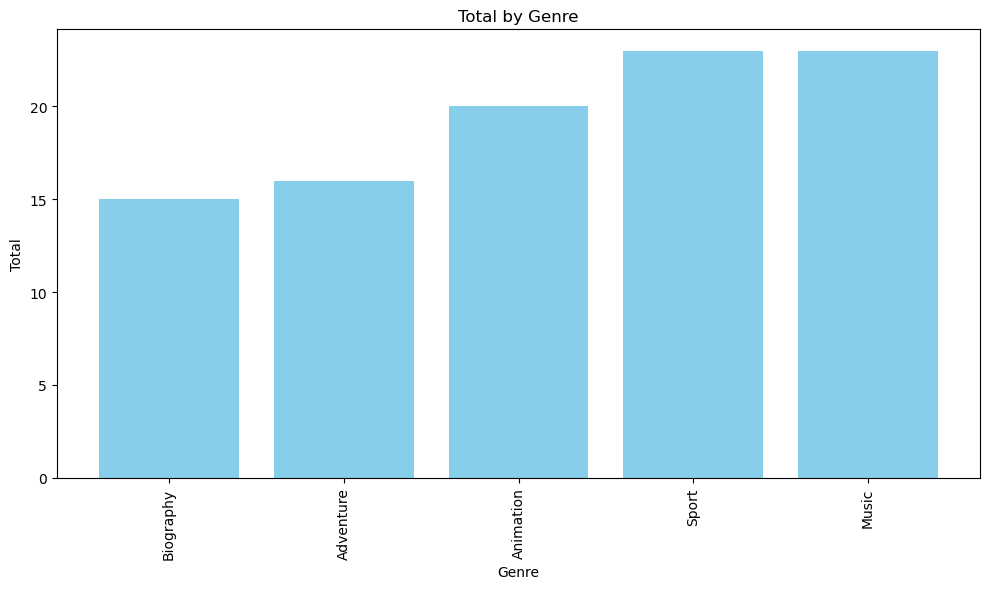

In [24]:
# Graph combining rating and vote column

plt.figure(figsize=(10,6))
plt.bar(top_5_combined['genre'],top_5_combined['Total'],color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Total')
plt.title('Total by Genre')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()

plt.show()

Observatons from Graph:
- This graph shows rankings with the lowest bar indicating the highest combined rating between votes and rank
- Biography, Adventure, Animation, Sport, Music are the top 5

Now let us explore the correlaton between run time and movie ratings

In [25]:
# Evaluate the values in the length column

basic_and_rating['length'].describe()

count    118437.000000
mean         95.090757
std         156.784852
min           3.000000
25%          82.000000
50%          92.000000
75%         105.000000
max       51420.000000
Name: length, dtype: float64

Most movies are around 90 minutes or an hour and a half long

Dataset Takeaways for Movie Basic and Movie Rating Datasets
- Biography, Adventure, and Animation are the highest ranked genres 
- Sci-Fi ranked #2 in number of votes
- Short ranked #1 in avg rating

In [26]:
# exploring start year column to understand range

start_year = pd.read_sql("""
SELECT start_year
FROM movie_basics
;""",conn)
start_year.value_counts()

start_year
2017          17504
2016          17272
2018          16849
2015          16243
2014          15589
2013          14709
2012          13787
2011          12900
2010          11849
2019           8379
2020            937
2021             83
2022             32
2023              5
2024              2
2025              1
2026              1
2027              1
2115              1
Name: count, dtype: int64

Looking at death year values to filter out deceased individuals

In [27]:
# exploring death year column to filter out deceased individuals

death_year = pd.read_sql("""
SELECT death_year
FROM persons
;""",conn)
death_year.value_counts()

death_year
2018.0        624
2017.0        621
2016.0        592
2015.0        540
2013.0        437
             ... 
1847.0          1
1848.0          1
1850.0          1
1854.0          1
17.0            1
Name: count, Length: 214, dtype: int64

Now we will look at director, writer, and persons tables to find correlations between specific personnel and movie success

In [28]:
# Combine writer, director, persons tables to return writer and director names with movie ids

# Properly formatted SQL query within triple quotes
brwd_df = pd.read_sql("""
    SELECT 
        p.person_id,
        p.primary_name,
        w.movie_id,
        mb.genres,
        mr.averagerating as avg_rating,
        mr.numvotes as num_of_votes,
        'writer' AS role
    FROM persons AS p
    JOIN writers AS w ON p.person_id = w.person_id
    JOIN movie_basics AS mb ON w.movie_id = mb.movie_id
    JOIN movie_ratings AS mr ON w.movie_id = mr.movie_id
    WHERE p.death_year IS NULL
    
    UNION ALL
    
    SELECT 
        p.person_id,
        p.primary_name,
        d.movie_id,
        mb.genres,
        mr.averagerating as avg_rating,
        mr.numvotes as num_of_votes,
        'director' AS role
    FROM persons AS p
    JOIN directors AS d ON p.person_id = d.person_id
    JOIN movie_basics AS mb ON d.movie_id = mb.movie_id
    JOIN movie_ratings AS mr ON d.movie_id = mr.movie_id
    WHERE p.death_year IS NULL
    ;
    """, conn)

brwd_df.head()


,person_id,primary_name,movie_id,genres,avg_rating,num_of_votes,role
0,nm0065847,Michael Frost Beckner,tt6349302,"Action,Drama,Thriller",5.6,1809,writer
1,nm0068874,Hava Kohav Beller,tt7701650,Documentary,5.4,11,writer
2,nm0072476,Doug Benson,tt1975283,Documentary,6.3,474,writer
3,nm0075666,Joe Berlinger,tt3137552,"Biography,Documentary,News",6.5,426,writer
4,nm0075666,Joe Berlinger,tt6794462,"Documentary,History",7.8,413,writer


In [94]:
brwd_df.shape

(346178, 7)

There are 34.6k row items for writers

We are now evaluating the correlation between certain writers and the success of their films
- We are using our combined database, filtering for writers with more than 10 movies, and sorting by avg_rating and num of votes

In [29]:
# Filter the DataFrame to include only writers
writers_df = brwd_df[brwd_df['role'] == 'writer']

# Group by 'primary_name' and aggregate 'numvotes', 'averagerating', and count the number of movies
top_writers = writers_df.groupby('primary_name').agg({
    'num_of_votes': 'mean',
    'avg_rating': 'mean',
    'movie_id': 'count'  # Counting the number of movies for each writer
}).rename(columns={'movie_id': 'movie_count'}).reset_index()

# Filter for writers with more than 10 movies
top_writers = top_writers[top_writers['movie_count'] > 20]

# Sort by 'averagerating' and 'numvotes' to get the top 10 writers
top_10_writers = top_writers.sort_values(by=['num_of_votes', 'avg_rating'], ascending=False).head(10)

print(top_10_writers)


            primary_name  num_of_votes  avg_rating  movie_count
657           Adam McKay  46633.406250    6.731250           32
8976          Brad Miska  36779.260870    5.473913           23
63921      Simon Barrett  27445.538462    5.140385           52
67956            Ti West  26198.575000    5.062500           40
64610  Srdjan Spasojevic  18189.607143    4.714286           28
36407      Kaare Andrews  16958.000000    4.700000           27
37422       Keith Calder  16958.000000    4.700000           27
40098     Lee Hardcastle  16958.000000    4.700000           27
44786    Martha Poly Vil  16958.000000    4.700000           27
49868    Nacho Vigalondo  16419.972973    4.754054           37


The Top 3 Writers with more than 20 movie:
1. Adam McKay
2. Brad Miska
3. Simon Barrett

In [30]:
top_3_writers = top_10_writers.nlargest(3,'num_of_votes')
top_3_writers

,primary_name,num_of_votes,avg_rating,movie_count
657,Adam McKay,46633.406250,6.731250,32
8976,Brad Miska,36779.260870,5.473913,23
63921,Simon Barrett,27445.538462,5.140385,52


Text(0.5, 1.0, 'Average # of Votes Per Film')

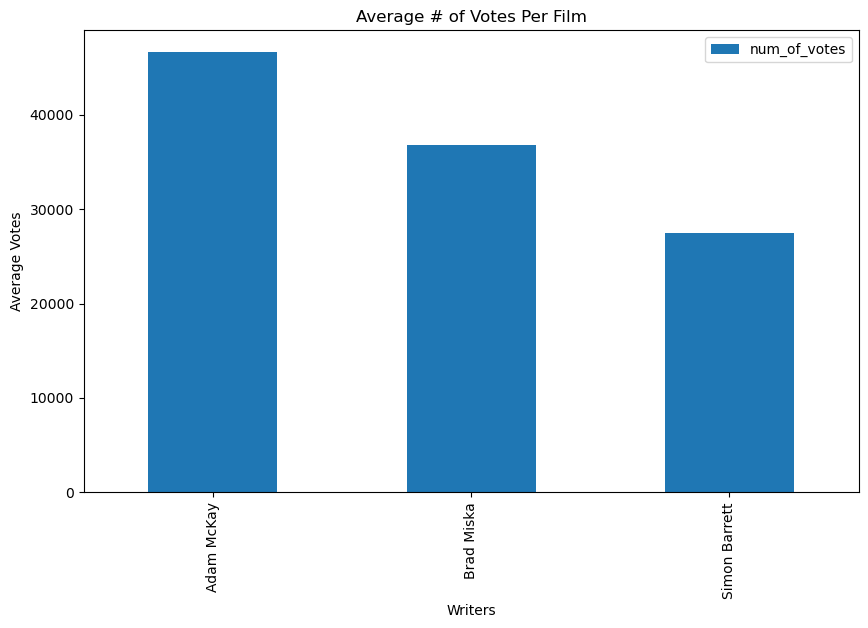

In [31]:
fig,ax =plt.subplots(figsize=(10,6))

top_3_writers.plot(kind='bar',ax=ax,x='primary_name',y='num_of_votes')
plt.xlabel('Writers')
plt.ylabel('Average Votes')
plt.title('Average # of Votes Per Film')

Lets group the writers dataframe into 3 buckets and see the difference in average rating and number of votes between these 3 groups

In [103]:
# Group brwd_df into 3 buckets based on average rating

quantiles = brwd_df['avg_rating'].quantile([0.33, 0.67]) # the 3 buckets are (0-5.7, 5.7 - 6.9, 6.9+ )

def rating_category(rating):
    if rating <= quantiles[.33]:
        return 3
    elif rating <= quantiles[.67]:
        return 2
    else:
        return 1

brwd_df['rating_category'] = brwd_df['avg_rating'].apply(rating_category)

brwd_df

,person_id,primary_name,movie_id,genres,avg_rating,num_of_votes,role,rating_category
0,nm0065847,Michael Frost Beckner,tt6349302,"Action,Drama,Thriller",5.6,1809,writer,3
1,nm0068874,Hava Kohav Beller,tt7701650,Documentary,5.4,11,writer,3
2,nm0072476,Doug Benson,tt1975283,Documentary,6.3,474,writer,2
3,nm0075666,Joe Berlinger,tt3137552,"Biography,Documentary,News",6.5,426,writer,2
4,nm0075666,Joe Berlinger,tt6794462,"Documentary,History",7.8,413,writer,1
...,...,...,...,...,...,...,...,...
346173,nm9748617,Frank W Chen,tt8234502,"Documentary,Sport",5.8,281,director,2
346174,nm9748617,Frank W Chen,tt8234502,"Documentary,Sport",5.8,281,director,2
346175,nm9769561,Prasobh Vijayan,tt8273258,Thriller,5.7,193,director,3
346176,nm9781362,Grzegorz Jankowski,tt4438688,"Comedy,Musical",5.2,215,director,3


In [107]:
rating_group = brwd_df.groupby('rating_category').agg({
    'avg_rating':'mean'
})

rating_group

,avg_rating
rating_category,
1,7.667341
2,6.346210
3,4.684077


We are now evaluating the correlation between certain directors and the success of their films

We are using our combined database, filtering for directors with more than 20 movies, and sorting by avg_rating and num of votes

In [32]:
# Filter the DataFrame to include only directors
directors_df = brwd_df[brwd_df['role'] == 'director']

# Group by 'primary_name' and aggregate 'numvotes', 'averagerating', and count the number of movies
top_directors = directors_df.groupby('primary_name').agg({
    'num_of_votes': 'mean',
    'avg_rating': 'mean',
    'movie_id': 'count'  # Counting the number of movies for each writer
}).rename(columns={'movie_id': 'movie_count'}).reset_index()

# Filter for writers with more than 20 movies
top_directors = top_directors[(top_directors['movie_count'] > 20) & (top_directors['num_of_votes'] > 1000)]

# Sort by 'averagerating' and 'numvotes' to get the top 10 writers
top_10_directors = top_directors.sort_values(by=['num_of_votes', 'avg_rating'], ascending=False).head(10)

print(top_10_directors)


         primary_name   num_of_votes  avg_rating  movie_count
4148    Anthony Russo  614053.100000    8.246667           30
24851       Joe Russo  594248.000000    8.180645           31
22174      James Gunn  414232.422222    6.266667           45
55849     Zack Snyder  406806.807692    6.619231           26
44083    Ridley Scott  291418.454545    6.595455           22
43759      Rich Moore  268025.739130    7.595652           23
13824        Don Hall  175720.750000    7.483333           24
47714     Seth Gordon  113739.375000    6.104167           24
41394  Peter Farrelly  103533.388889    5.094444           36
7109     Brett Ratner  103463.250000    4.821429           28


C:\Users\alecs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\alecs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\alecs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\alecs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

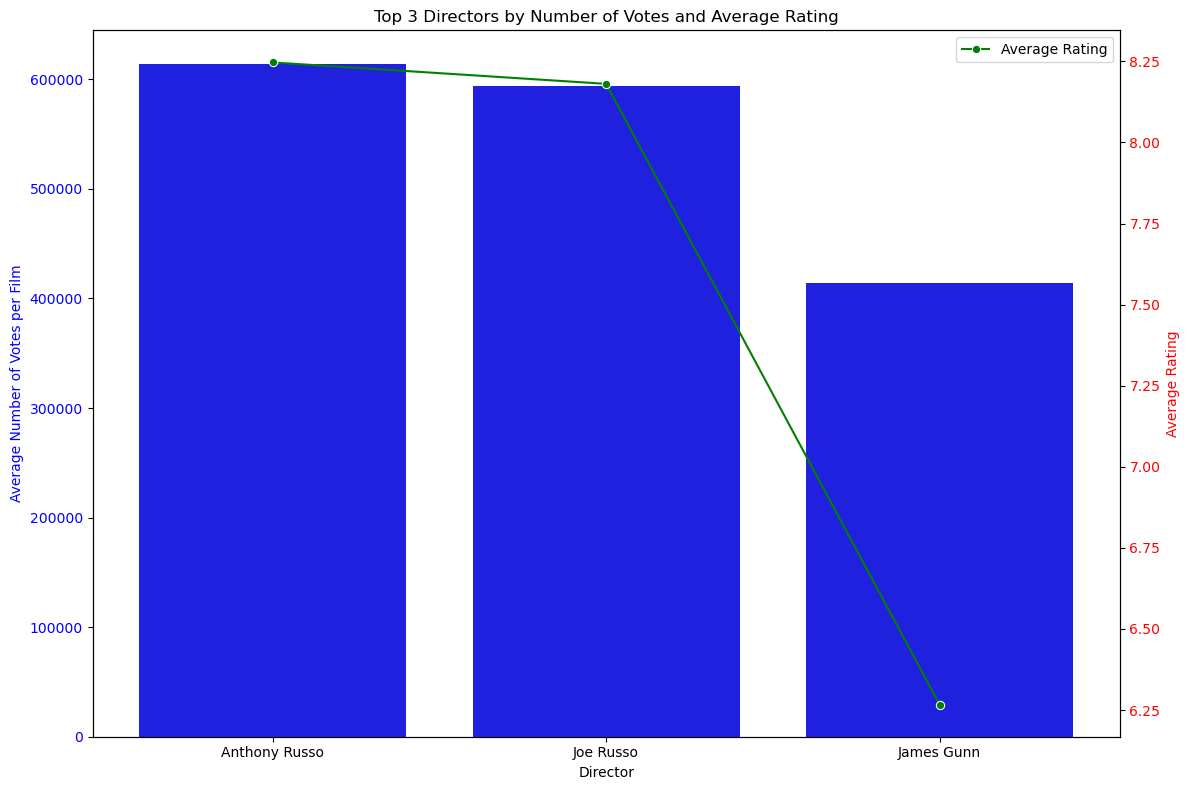

In [33]:
# Visualize the statistics of the top 3 directors


top_3_directors = top_10_directors.nlargest(3, 'num_of_votes')

# Create the Bar Graph
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar plot for num_of_votes
sns.barplot(data=top_3_directors, x='primary_name', y='num_of_votes', ax=ax1, color='b', label='Number of Votes')
ax1.set_xlabel('Director')
ax1.set_ylabel('Average Number of Votes per Film', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Top 3 Directors by Number of Votes and Average Rating')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Line plot for avg_rating
sns.lineplot(data=top_3_directors, x='primary_name', y='avg_rating', ax=ax2, color='g', marker='o', label='Average Rating')
ax2.set_ylabel('Average Rating', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

The top 3 directors with more than 20 films are:
1. Anthony Russo
2. Joe Rsso
3. S.S. Rajamouli

In [108]:
# Evaluate the quantiles of top directors 

# Group brwd_df into 3 buckets based on average rating

quantiles = directors_df['avg_rating'].quantile([0.33, 0.67]) # the 3 buckets are (0-5.7, 5.7 - 6.9, 6.9+ )

def rating_category(rating):
    if rating <= quantiles[.33]:
        return 3
    elif rating <= quantiles[.67]:
        return 2
    else:
        return 1

directors_df['rating_category'] = directors_df['avg_rating'].apply(rating_category)

directors_df

C:\Users\alecs\AppData\Local\Temp\ipykernel_13824\1900958080.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  directors_df['rating_category'] = directors_df['avg_rating'].apply(rating_category)


,person_id,primary_name,movie_id,genres,avg_rating,num_of_votes,role,rating_category
166133,nm0062879,Ruel S. Bayani,tt1592569,"Drama,Romance",6.4,77,director,2
166134,nm0062879,Ruel S. Bayani,tt1592569,"Drama,Romance",6.4,77,director,2
166135,nm0062879,Ruel S. Bayani,tt1592569,"Drama,Romance",6.4,77,director,2
166136,nm0062879,Ruel S. Bayani,tt1592569,"Drama,Romance",6.4,77,director,2
166137,nm0062879,Ruel S. Bayani,tt2057445,"Drama,Romance,Thriller",6.4,256,director,2
...,...,...,...,...,...,...,...,...
346173,nm9748617,Frank W Chen,tt8234502,"Documentary,Sport",5.8,281,director,2
346174,nm9748617,Frank W Chen,tt8234502,"Documentary,Sport",5.8,281,director,2
346175,nm9769561,Prasobh Vijayan,tt8273258,Thriller,5.7,193,director,3
346176,nm9781362,Grzegorz Jankowski,tt4438688,"Comedy,Musical",5.2,215,director,3


In [109]:
director_rating_group = directors_df.groupby('rating_category').agg({
    'avg_rating':'mean'
})

director_rating_group

,avg_rating
rating_category,
1,7.679156
2,6.348419
3,4.681315


In [34]:
# Combine the movie_basics table and movie_ratings table to evalute runtime 

In [35]:
# Lets bucket the length of movies into 3 distinct buckets: short, average, long

# Define the bins and labels for bucketing movie lengths
bins = [0, 75, 100, 120, 180, 240, float('inf')]
labels = ['0-75', '76-100', '101-120', '121-180','181-239', '240+']

# Create a new column with the bucket labels using pd.cut
basic_and_rating['movie_lengths'] = pd.cut(basic_and_rating['length'], bins=bins, labels=labels, right=False)

# Print the DataFrame to check the new column
basic_and_rating

,movie_id,avg_rating,num_of_votes,primary_title,length,genre,movie_lengths
0,tt0063540,7.0,77,Sunghursh,175.0,Action,121-180
0,tt0063540,7.0,77,Sunghursh,175.0,Crime,121-180
0,tt0063540,7.0,77,Sunghursh,175.0,Drama,121-180
1,tt0066787,7.2,43,One Day Before the Rainy Season,114.0,Biography,101-120
1,tt0066787,7.2,43,One Day Before the Rainy Season,114.0,Drama,101-120
...,...,...,...,...,...,...,...
73850,tt9913056,6.2,5,Swarm Season,86.0,Documentary,76-100
73851,tt9913084,6.2,6,Diabolik sono io,75.0,Documentary,76-100
73852,tt9914286,8.7,136,Sokagin Çocuklari,98.0,Drama,76-100
73852,tt9914286,8.7,136,Sokagin Çocuklari,98.0,Family,76-100


Let us evaluate the correlation between num of votes and runtime and avg rating and runtime

In [36]:
grouped_corr = basic_and_rating.groupby('movie_lengths').agg({
    'avg_rating':['mean','count'],
    'num_of_votes':['mean','count']
}).reset_index()

print(grouped_corr)

  movie_lengths avg_rating         num_of_votes       
                      mean  count          mean  count
0          0-75   6.839697  16092     96.392369  16092
1        76-100   6.108542  62666   2362.623177  62666
2       101-120   6.298780  25497  10483.242891  25497
3       121-180   6.465522  13739  19122.730257  13739
4       181-239   7.163344    311  17440.559486    311
5          240+   7.240909    132   2410.977273    132


C:\Users\alecs\AppData\Local\Temp\ipykernel_13824\2733261076.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_corr = basic_and_rating.groupby('movie_lengths').agg({


C:\Users\alecs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\alecs\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


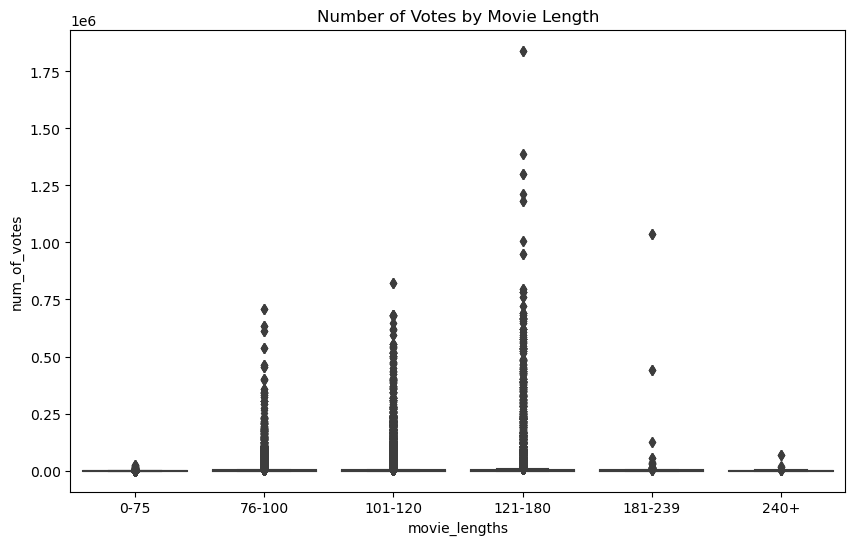

In [37]:
# We will visualize the resutls to determine correlation between groups

plt.figure(figsize=(10,6))
sns.boxplot(x='movie_lengths',y='num_of_votes',data=basic_and_rating)
plt.title('Number of Votes by Movie Length')
plt.show()

Obeservations from this graph:
- Popularity Trends: Movies in the length range of 121-240 tend to receive the highest number of votes, followed by movies in the 101-120 and 76-100 ranges. Movies that are very short (0-75) or very long (240+) generally receive fewer votes.


C:\Users\alecs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\alecs\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


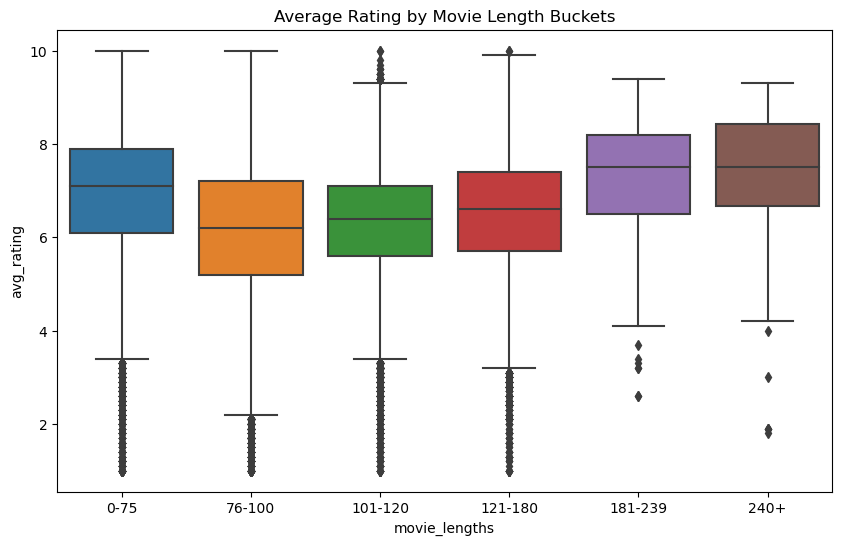

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='movie_lengths', y='avg_rating', data=basic_and_rating)
plt.title('Average Rating by Movie Length Buckets')
plt.show()

Observations from this graph:
- Movies with lengths in the 0-75 and 240+ minutes buckets tend to have higher median ratings compared to other buckets.
- Movies in the 76-240 minutes range have relatively consistent median ratings, but with more lower-end outliers.

#### Dataset 2: bom.movie_gross.csv.gz

Explore components of movie_gross dataset

In [39]:
# Load in the dataset and explore
csv_file = r'C:\Users\alecs\OneDrive\Desktop\Flatiron School\Phase 2 Project\dsc-phase-2-project-as\datasets\bom.movie_gross.csv.gz'
movie_gross = pd.read_csv(csv_file)
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [40]:
# Describe function

movie_gross.describe()

,domestic_gross,year
count,3.359000e+03,3387.000000
mean,2.874585e+07,2013.958075
std,6.698250e+07,2.478141
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.400000e+06,2014.000000
75%,2.790000e+07,2016.000000
max,9.367000e+08,2018.000000


In [41]:
#update name for title to primary_title to match other datasets

movie_gross = movie_gross.rename(columns={'title':'primary_title'})
movie_gross

,primary_title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


Merge databases to evaluate gross movie results with other key variables

In [42]:

gross_joined = pd.merge(movie_gross, basic_and_rating, on ='primary_title',how='inner')
gross_joined

,primary_title,studio,domestic_gross,foreign_gross,year,movie_id,avg_rating,num_of_votes,length,genre,movie_lengths
0,Toy Story 3,BV,415000000.0,652000000,2010,tt0435761,8.3,682218,103.0,Adventure,101-120
1,Toy Story 3,BV,415000000.0,652000000,2010,tt0435761,8.3,682218,103.0,Animation,101-120
2,Toy Story 3,BV,415000000.0,652000000,2010,tt0435761,8.3,682218,103.0,Comedy,101-120
3,Inception,WB,292600000.0,535700000,2010,tt1375666,8.8,1841066,148.0,Action,121-180
4,Inception,WB,292600000.0,535700000,2010,tt1375666,8.8,1841066,148.0,Adventure,121-180
...,...,...,...,...,...,...,...,...,...,...,...
6910,Beauty and the Dogs,Osci.,8900.0,NaN,2018,tt6776572,7.0,1016,100.0,Thriller,101-120
6911,The Quake,Magn.,6200.0,NaN,2018,tt6523720,6.2,5270,106.0,Action,101-120
6912,The Quake,Magn.,6200.0,NaN,2018,tt6523720,6.2,5270,106.0,Drama,101-120
6913,The Quake,Magn.,6200.0,NaN,2018,tt6523720,6.2,5270,106.0,Thriller,101-120


In [43]:
# Let's create a column for total_gross that equals domestic + foreign
# first we must ensure they are the same data type
print(gross_joined['domestic_gross'].dtype)
print(gross_joined['foreign_gross'].dtype)

float64
object


In [44]:
# Remove commas and convert to float
gross_joined['foreign_gross'] = gross_joined['foreign_gross'].astype(str).str.replace(',', '')
gross_joined['foreign_gross'] = gross_joined['foreign_gross'].astype(float)
print(gross_joined['foreign_gross'].dtype)

float64


In [45]:
# combine domestic and foreign gross columns

gross_joined['total_gross'] = gross_joined['foreign_gross'] + gross_joined['domestic_gross']
gross_joined

,primary_title,studio,domestic_gross,foreign_gross,year,movie_id,avg_rating,num_of_votes,length,genre,movie_lengths,total_gross
0,Toy Story 3,BV,415000000.0,652000000.0,2010,tt0435761,8.3,682218,103.0,Adventure,101-120,1.067000e+09
1,Toy Story 3,BV,415000000.0,652000000.0,2010,tt0435761,8.3,682218,103.0,Animation,101-120,1.067000e+09
2,Toy Story 3,BV,415000000.0,652000000.0,2010,tt0435761,8.3,682218,103.0,Comedy,101-120,1.067000e+09
3,Inception,WB,292600000.0,535700000.0,2010,tt1375666,8.8,1841066,148.0,Action,121-180,8.283000e+08
4,Inception,WB,292600000.0,535700000.0,2010,tt1375666,8.8,1841066,148.0,Adventure,121-180,8.283000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...
6910,Beauty and the Dogs,Osci.,8900.0,NaN,2018,tt6776572,7.0,1016,100.0,Thriller,101-120,NaN
6911,The Quake,Magn.,6200.0,NaN,2018,tt6523720,6.2,5270,106.0,Action,101-120,NaN
6912,The Quake,Magn.,6200.0,NaN,2018,tt6523720,6.2,5270,106.0,Drama,101-120,NaN
6913,The Quake,Magn.,6200.0,NaN,2018,tt6523720,6.2,5270,106.0,Thriller,101-120,NaN


In [46]:
# Evaluate year values to filter towards more recent years
gross_joined['year'].value_counts()

year
2015    940
2016    929
2011    833
2012    793
2014    791
2017    720
2013    702
2018    663
2010    544
Name: count, dtype: int64

The dataset only contains data dating back to 2010 which is recent enough to include all the data

We will filter on the top 2,000 grossing movies out of the 6,915 in the dataset to focus on the most successful films

In [61]:
top_gross = gross_joined.sort_values(by=['total_gross'],ascending = False)
top_gross_2000 = top_gross.head(2000)
top_gross_2000

,primary_title,studio,domestic_gross,foreign_gross,year,movie_id,avg_rating,num_of_votes,length,genre,movie_lengths,total_gross
3671,Avengers: Age of Ultron,BV,459000000.0,946400000.0,2015,tt2395427,7.3,665594,141.0,Action,121-180,1.405400e+09
3673,Avengers: Age of Ultron,BV,459000000.0,946400000.0,2015,tt2395427,7.3,665594,141.0,Sci-Fi,121-180,1.405400e+09
3672,Avengers: Age of Ultron,BV,459000000.0,946400000.0,2015,tt2395427,7.3,665594,141.0,Adventure,121-180,1.405400e+09
6256,Black Panther,BV,700100000.0,646900000.0,2018,tt1825683,7.3,516148,134.0,Adventure,121-180,1.347000e+09
6257,Black Panther,BV,700100000.0,646900000.0,2018,tt1825683,7.3,516148,134.0,Sci-Fi,121-180,1.347000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
5752,Monster Trucks,Par.,33400000.0,31100000.0,2017,tt3095734,5.7,13525,104.0,Action,101-120,6.450000e+07
5754,Monster Trucks,Par.,33400000.0,31100000.0,2017,tt3095734,5.7,13525,104.0,Comedy,101-120,6.450000e+07
4845,Fences,Par.,57700000.0,6700000.0,2016,tt2671706,7.2,86749,139.0,Drama,121-180,6.440000e+07
3883,The Danish Girl,Focus,11100000.0,53100000.0,2015,tt0810819,7.1,146873,119.0,Biography,101-120,6.420000e+07


Text(0.5, 1.0, 'Gross Income by Genre')

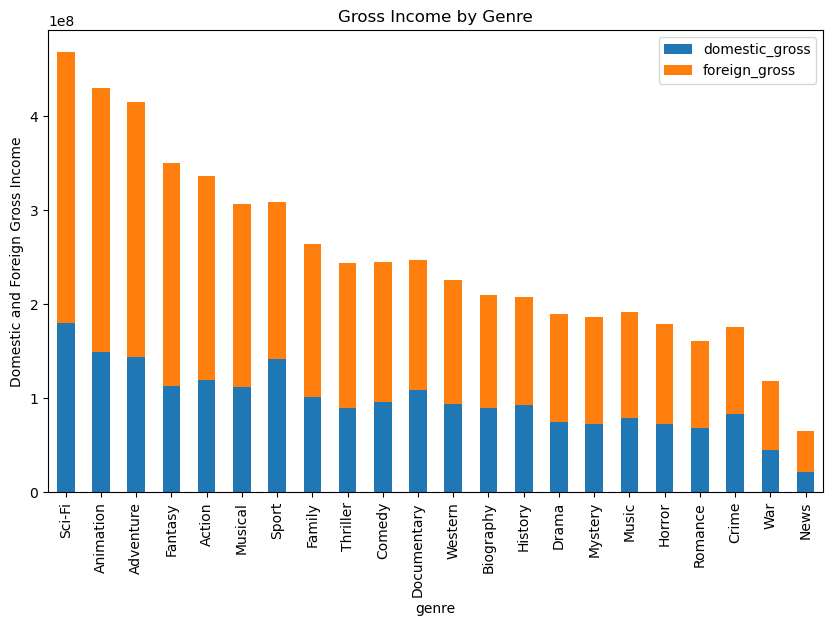

In [62]:
genre_count = top_gross_2000.groupby('genre')[['domestic_gross','foreign_gross']].mean()
genre_count_sort = genre_count.sort_values(by='foreign_gross',ascending = False)
fig, ax = plt.subplots(figsize=(10,6))
genre_count_sort.plot(kind='bar',stacked=True, ax=ax)
plt.ylabel('Domestic and Foreign Gross Income')
plt.title('Gross Income by Genre')

Graph Observations
1. Sci-Fi is by far the most successful genre 
2. Top 5 Genres in order: Sci-Fi, Animation, Adventure, Fantasy, ACtion
3. Foreign gross seems to count for a much higher percentage of income overall

In [63]:
genre_count_sort['Total'] = genre_count_sort['domestic_gross'] + genre_count_sort['foreign_gross']
genre_count_sorted= genre_count_sort.sort_values(['Total'],ascending = False)
genre_count_sorted

,domestic_gross,foreign_gross,Total
genre,,,
Sci-Fi,1.797581e+08,2.881210e+08,4.678791e+08
Animation,1.492141e+08,2.804080e+08,4.296221e+08
Adventure,1.434882e+08,2.714110e+08,4.148992e+08
Fantasy,1.131432e+08,2.372907e+08,3.504339e+08
Action,1.193251e+08,2.165629e+08,3.358880e+08
Sport,1.420083e+08,1.661583e+08,3.081667e+08
Musical,1.114333e+08,1.950667e+08,3.065000e+08
Family,1.009708e+08,1.630271e+08,2.639979e+08
Documentary,1.083095e+08,1.390619e+08,2.473714e+08


In [70]:
# Let us group by year, genre, and total gross to see if preferences have changed over the years

gross_by_year = top_gross_2000.groupby(['year','genre']).agg({'total_gross':'sum'
}).reset_index()

# Filter for the top 5 grossing genres each year to drill down on changing preferences

top_5_genres_per_year = gross_by_year.sort_values(['year', 'total_gross'], ascending=[True, False]).groupby('year').head(5)

top_5_genres_per_year

,year,genre,total_gross
1,2010,Adventure,9.515300e+09
0,2010,Action,7.558300e+09
4,2010,Comedy,6.811100e+09
7,2010,Drama,5.840200e+09
2,2010,Animation,4.112900e+09
22,2011,Adventure,1.027030e+10
21,2011,Action,1.021410e+10
25,2011,Comedy,6.996000e+09
28,2011,Drama,4.611100e+09
23,2011,Animation,4.275400e+09


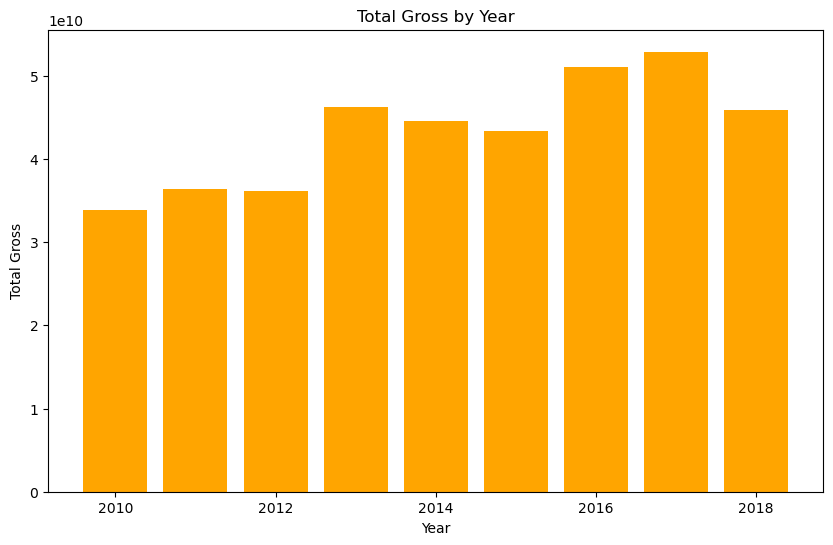

In [77]:
# Grouping the data by year and summing the total_gross
grouped_data = top_5_genres_per_year.groupby('year')['total_gross'].sum().reset_index()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(grouped_data['year'], grouped_data['total_gross'], color='orange')
plt.xlabel('Year')
plt.ylabel('Total Gross')
plt.title('Total Gross by Year')
plt.show()

Takeaways from above graph
- Gross income has increased significantly since 2010 but YoY growth is unpredictable

In [78]:
pivot_df = top_5_genres_per_year.pivot(index='year', columns='genre', values='total_gross').fillna(0)
pivot_df

genre,Action,Adventure,Animation,Comedy,Drama,Fantasy,Sci-Fi,Thriller
year,,,,,,,,
2010,7.558300e+09,9.515300e+09,4.112900e+09,6.811100e+09,5.840200e+09,0.000000e+00,0.000000e+00,0.000000e+00
2011,1.021410e+10,1.027030e+10,4.275400e+09,6.996000e+09,4.611100e+09,0.000000e+00,0.000000e+00,0.000000e+00
2012,8.869049e+09,1.074630e+10,0.000000e+00,7.393185e+09,4.598200e+09,0.000000e+00,0.000000e+00,4.524800e+09
2013,1.020289e+10,1.557335e+10,0.000000e+00,7.485633e+09,7.181445e+09,0.000000e+00,5.810700e+09,0.000000e+00
2014,1.288112e+10,1.317492e+10,0.000000e+00,5.829696e+09,6.476053e+09,0.000000e+00,6.258800e+09,0.000000e+00
2015,1.064231e+10,1.285342e+10,0.000000e+00,8.772000e+09,6.594085e+09,0.000000e+00,4.460701e+09,0.000000e+00
2016,1.312803e+10,1.586813e+10,6.325900e+09,9.679170e+09,6.112337e+09,0.000000e+00,0.000000e+00,0.000000e+00
2017,1.475290e+10,1.502797e+10,0.000000e+00,9.431426e+09,7.435772e+09,6.255552e+09,0.000000e+00,0.000000e+00
2018,1.318949e+10,1.397189e+10,0.000000e+00,7.343906e+09,5.529700e+09,0.000000e+00,5.832007e+09,0.000000e+00


Text(0.5, 1.0, 'Top Genres By Gross Income per Year')

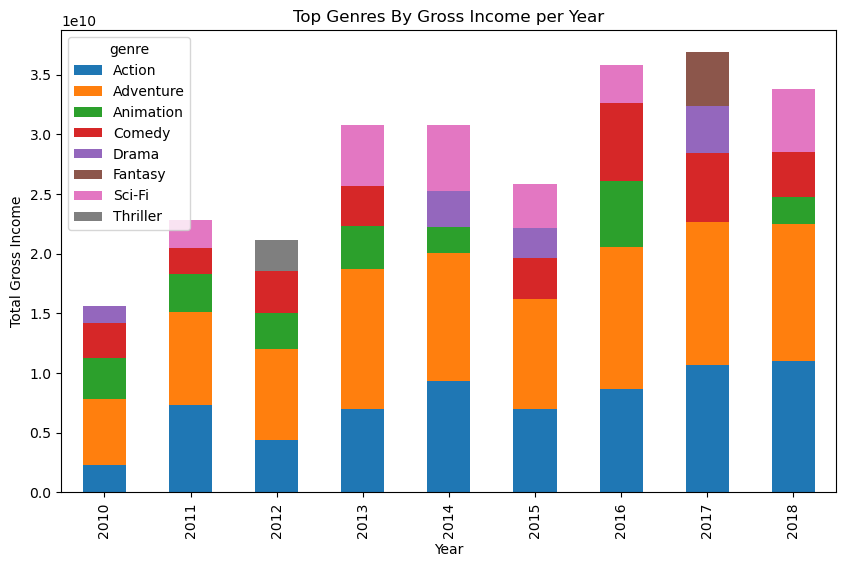

In [53]:
fig,ax = plt.subplots(figsize=(10,6))

pivot_df.plot(kind='bar',stacked = True, ax=ax)
plt.ylabel('Total Gross Income')
plt.xlabel('Year')
plt.title('Top Genres By Gross Income per Year')

In [54]:
pivot_df

genre,Action,Adventure,Animation,Comedy,Drama,Fantasy,Sci-Fi,Thriller
year,,,,,,,,
2010,2.306200e+09,5.472700e+09,3.449400e+09,2.954500e+09,1.468500e+09,0.000000e+00,0.000000e+00,0.000000e+00
2011,7.285600e+09,7.788200e+09,3.205100e+09,2.197300e+09,0.000000e+00,0.000000e+00,2.329800e+09,0.000000e+00
2012,4.418600e+09,7.626800e+09,2.994200e+09,3.543600e+09,0.000000e+00,0.000000e+00,0.000000e+00,2.569700e+09
2013,6.977300e+09,1.177680e+10,3.578600e+09,3.353400e+09,0.000000e+00,0.000000e+00,5.140000e+09,0.000000e+00
2014,9.296100e+09,1.078460e+10,2.152500e+09,0.000000e+00,3.030000e+09,0.000000e+00,5.541700e+09,0.000000e+00
2015,6.946502e+09,9.240601e+09,0.000000e+00,3.425500e+09,2.532700e+09,0.000000e+00,3.719601e+09,0.000000e+00
2016,8.688833e+09,1.190093e+10,5.487500e+09,6.580933e+09,0.000000e+00,0.000000e+00,3.142900e+09,0.000000e+00
2017,1.063660e+10,1.199490e+10,0.000000e+00,5.844500e+09,3.882700e+09,4.532000e+09,0.000000e+00,0.000000e+00
2018,1.101610e+10,1.143581e+10,2.300600e+09,3.760206e+09,0.000000e+00,0.000000e+00,5.278107e+09,0.000000e+00


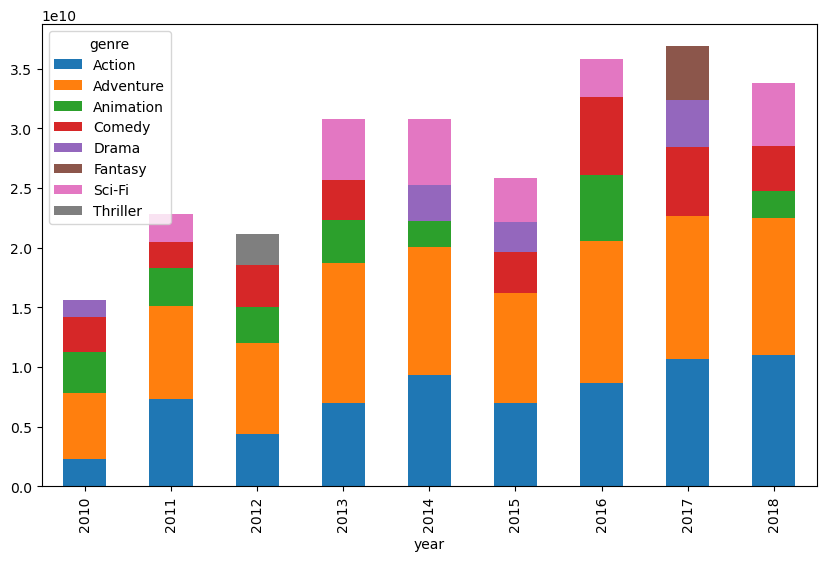

In [55]:
# Lets add YoY % change to the graph 

df_pct_change = pivot_df.pct_change() * 100

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = pivot_df.plot(kind='bar', stacked=True, ax=ax)



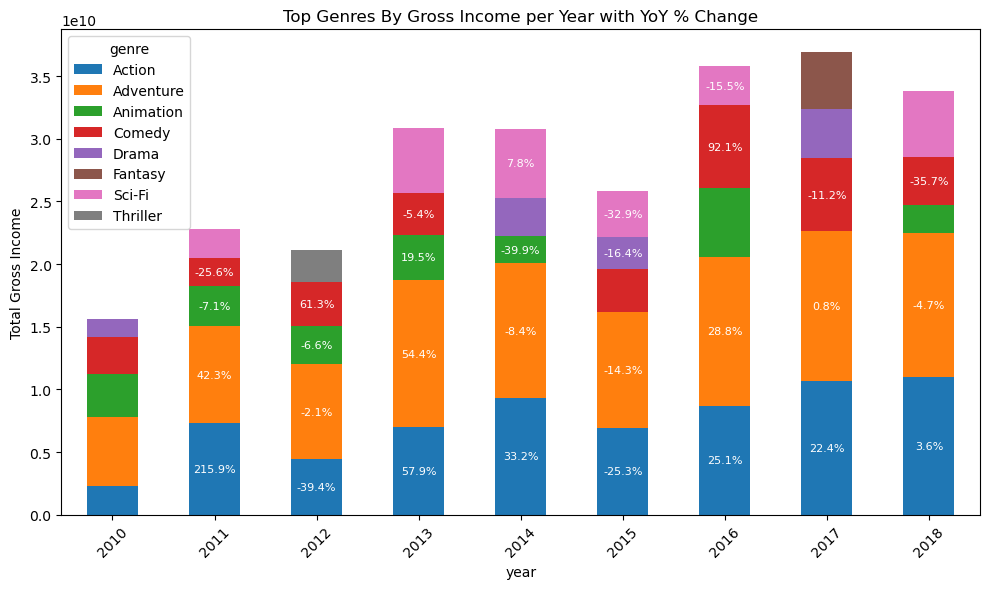

In [56]:
# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
pivot_df.plot(kind='bar', stacked=True, ax=ax)
plt.ylabel('Total Gross Income')
plt.title('Top Genres By Gross Income per Year with YoY % Change')

# Annotate each segment with YoY percentage change
for i in range(1, len(pivot_df)):  # Start from 1 to skip the first row (no previous year to compare)
    for genre in pivot_df.columns:
        pct_change = df_pct_change.iloc[i][genre]
        y1 = pivot_df.iloc[i][genre]  # Current year's value

        # Calculate the position to annotate
        previous_heights = pivot_df.iloc[i].cumsum() - pivot_df.iloc[i]
        height = previous_heights[genre] + y1 / 2

        # Annotate the percentage change
        # Annotate the percentage change
        if np.isfinite(pct_change) and y1 > 0:  
            # Annotate only if pct_change is finite and the current year's value is greater than 0
            ax.annotate(f'{pct_change:.1f}%', 
                        xy=(i, height), 
                        ha='center', va='center', color='white', fontsize=8)
        else:
            # Handle the case where pct_change is infinite or y1 <= 0
            # Annotate with a blank string
            ax.annotate('', 
                        xy=(i, height), 
                        ha='center', va='center', color='white', fontsize=8)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [57]:
pivot_df

genre,Action,Adventure,Animation,Comedy,Drama,Fantasy,Sci-Fi,Thriller
year,,,,,,,,
2010,2.306200e+09,5.472700e+09,3.449400e+09,2.954500e+09,1.468500e+09,0.000000e+00,0.000000e+00,0.000000e+00
2011,7.285600e+09,7.788200e+09,3.205100e+09,2.197300e+09,0.000000e+00,0.000000e+00,2.329800e+09,0.000000e+00
2012,4.418600e+09,7.626800e+09,2.994200e+09,3.543600e+09,0.000000e+00,0.000000e+00,0.000000e+00,2.569700e+09
2013,6.977300e+09,1.177680e+10,3.578600e+09,3.353400e+09,0.000000e+00,0.000000e+00,5.140000e+09,0.000000e+00
2014,9.296100e+09,1.078460e+10,2.152500e+09,0.000000e+00,3.030000e+09,0.000000e+00,5.541700e+09,0.000000e+00
2015,6.946502e+09,9.240601e+09,0.000000e+00,3.425500e+09,2.532700e+09,0.000000e+00,3.719601e+09,0.000000e+00
2016,8.688833e+09,1.190093e+10,5.487500e+09,6.580933e+09,0.000000e+00,0.000000e+00,3.142900e+09,0.000000e+00
2017,1.063660e+10,1.199490e+10,0.000000e+00,5.844500e+09,3.882700e+09,4.532000e+09,0.000000e+00,0.000000e+00
2018,1.101610e+10,1.143581e+10,2.300600e+09,3.760206e+09,0.000000e+00,0.000000e+00,5.278107e+09,0.000000e+00


This is an interesting view but lets look at the total % change from 2010 to 2018 across each genre


In [90]:
# Update index to genre

genre_pct_change = ((pivot_df.loc[2018] - pivot_df.loc[2010]) / pivot_df.loc[2010]) * 100

pct_df= pd.DataFrame(genre_pct_change)
pct_df = pct_df.rename(columns={0:'percentage_change'})
pct_df = pct_df.sort_values(by='percentage_change')
pct_df

,percentage_change
genre,
Animation,-100.000000
Drama,-5.316599
Comedy,7.822613
Adventure,46.836089
Action,74.503372
Sci-Fi,inf
Fantasy,NaN
Thriller,NaN


---

# Conclusions

1. Focus on the top grossing genres: Action, Adventure, & Sci-Fi
2. Movie lengths should be around 120 minutes
3. Strictly use writers and directors in the top 2/3 of average rating, the dropoff in the bottom third is substantial 

---

# Recomendations

### My recommendation is to focus on a narrow subset of films with genres being Action, Adventure, and/or Sci-Fi, movie length should be around 120 minutes, and directors / writers should have 20 movies under their belt and in top 2/3 of average rating.

#### This recommnedation is supported by 4 key pieces of evidence:
1. Action, Adventure, and Sci-Fi films have the highest gross income, average rating, and number of votes
2. Movie lengths in the 120 minute bucket received the highest number of votes
3. The difference between writers / directors in the top 2/3 versus the bottom 1/3 is substantial

---

# Next Steps
- Monitor success of films the new studio produces and optimize variables based on feedback and shifting trends